## Import Dependencies

In [99]:
import pandas as pd
import numpy as np
import psycopg2
import re
import config as creds
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sqlalchemy import create_engine
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# allow plots to appear directly in the notebook
%matplotlib inline

## Connect to Postgres RDS

In [100]:
DATABASES = {
    'production':{
        'NAME': creds.PGDATABASE,
        'USER': creds.PGUSER,
        'PASSWORD': creds.PGPASSWORD,
        'HOST': creds.PGHOST,
        'PORT': 5432,
    },
}

#Choose the database to use
db = DATABASES['production']

In [101]:
#construct an engine connection string
engine_string = "postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}".format(
    user = db['USER'],
    password = db['PASSWORD'],
    host = db['HOST'],
    port = db['PORT'],
    database = db['NAME'],
)

# create sqlalchemy engine
engine = create_engine(engine_string)

## Load Data

In [102]:
#Create dataframe from database
biodiversity_df = pd.read_sql_table('biodiversity_df', engine)

In [103]:
#Drop columns no longer needed
biodiversity_df = biodiversity_df.drop(columns=['NonNative_Ratio', 'NonNative_to_Native_Ratio'])
biodiversity_df

,Park Name,Park Code,State,ACRES,Latitude,Longitude,Average,Native,Not Native,Unknown,...,Fish,Fungi,Insect,Invertebrate,Mammal,Nonvascular Plant,Reptile,Slug/Snail,Spider/Scorpion,Vascular Plant
0,Acadia National Park,ACAD,ME,47390,44.35,-68.21,2872667,1189.0,486.0,33.0,...,38.0,0.0,0.0,0.0,55.0,0.0,11.0,0.0,0.0,1226.0
1,Arches National Park,ARCH,UT,76519,38.68,-109.57,1334063,939.0,108.0,1.0,...,11.0,0.0,0.0,0.0,59.0,0.0,20.0,0.0,0.0,745.0
2,Badlands National Park,BADL,SD,242756,43.75,-102.50,951227,779.0,100.0,35.0,...,24.0,173.0,239.0,1.0,64.0,0.0,13.0,0.0,1.0,625.0
3,Big Bend National Park,BIBE,TX,801163,29.25,-103.25,377154,2108.0,112.0,9.0,...,53.0,0.0,0.0,0.0,89.0,48.0,62.0,0.0,0.0,1589.0
4,Biscayne National Park,BISC,FL,172924,25.65,-80.08,509950,751.0,241.0,620.0,...,818.0,0.0,11.0,34.0,28.0,0.0,40.0,0.0,0.0,554.0
5,Black Canyon of the Gunnison National Park,BLCA,CO,32950,38.57,-107.72,239225,975.0,130.0,1.0,...,16.0,0.0,0.0,0.0,67.0,0.0,11.0,0.0,0.0,835.0
6,Bryce Canyon National Park,BRCA,UT,35835,37.57,-112.18,1867144,1186.0,98.0,2.0,...,1.0,0.0,0.0,0.0,76.0,0.0,13.0,0.0,0.0,975.0
7,Canyonlands National Park,CANY,UT,337598,38.20,-109.93,599385,1103.0,120.0,0.0,...,33.0,0.0,0.0,0.0,76.0,0.0,22.0,0.0,0.0,865.0
8,Capitol Reef National Park,CARE,UT,241904,38.20,-111.17,906527,1406.0,158.0,2.0,...,15.0,0.0,0.0,0.0,73.0,0.0,21.0,0.0,0.0,1203.0
9,Carlsbad Caverns National Park,CAVE,NM,46766,32.17,-104.44,429958,1398.0,73.0,11.0,...,5.0,0.0,0.0,0.0,92.0,0.0,62.0,0.0,0.0,995.0


## Correlation Exploration

In [104]:
biodiversity_df.corr(method='pearson')

,ACRES,Latitude,Longitude,Average,Native,Not Native,Unknown,total_species,Algae,Amphibian,...,Fish,Fungi,Insect,Invertebrate,Mammal,Nonvascular Plant,Reptile,Slug/Snail,Spider/Scorpion,Vascular Plant
ACRES,1.000000,0.587047,-0.493968,-0.110923,0.054969,-0.203815,-0.024700,-0.042575,0.034666,-0.062390,...,0.016782,0.065866,-0.026959,-0.066732,0.053261,-0.056205,-0.157489,0.013106,-0.014263,0.027527
Latitude,0.587047,1.000000,-0.489089,-0.163184,-0.167521,-0.503996,-0.007645,-0.295138,0.022840,-0.242405,...,-0.185524,0.172110,-0.227685,-0.123073,-0.040733,0.093167,-0.560898,-0.182882,-0.268887,-0.160814
Longitude,-0.493968,-0.489089,1.000000,0.228686,0.057916,-0.026062,0.165114,0.096098,-0.009937,0.432127,...,0.265619,-0.046188,-0.009840,-0.155107,0.032996,-0.097490,0.401617,-0.102497,-0.069166,0.166563
Average,-0.110923,-0.163184,0.228686,1.000000,0.607455,0.251308,0.093850,0.546664,0.093202,0.355366,...,-0.089899,0.123059,0.537934,0.031792,0.208188,0.346885,0.177355,0.254151,0.510313,0.442573
Native,0.054969,-0.167521,0.057916,0.607455,1.000000,0.321662,0.125573,0.856458,0.167608,0.367292,...,-0.113504,0.194297,0.464831,0.187222,0.359289,0.401155,0.320771,0.347564,0.425463,0.721978
Not Native,-0.203815,-0.503996,-0.026062,0.251308,0.321662,1.000000,0.059593,0.595615,-0.059500,0.110328,...,0.096916,0.081574,0.490255,0.379697,-0.248238,0.228443,0.034064,0.401213,0.379305,0.246164
Unknown,-0.024700,-0.007645,0.165114,0.093850,0.125573,0.059593,1.000000,0.501329,0.380896,0.047502,...,0.209855,0.232163,0.298437,0.068270,-0.043201,0.307796,-0.081981,0.072958,0.084455,0.166063
total_species,-0.042575,-0.295138,0.096098,0.546664,0.856458,0.595615,0.501329,1.000000,0.245532,0.312388,...,0.037446,0.254769,0.611320,0.289335,0.146142,0.479471,0.202547,0.410106,0.461124,0.652855
Algae,0.034666,0.022840,-0.009937,0.093202,0.167608,-0.059500,0.380896,0.245532,1.000000,0.173604,...,0.042569,0.259700,0.476535,0.463789,0.251266,0.213565,-0.015181,0.387481,0.087883,0.205354
Amphibian,-0.062390,-0.242405,0.432127,0.355366,0.367292,0.110328,0.047502,0.312388,0.173604,1.000000,...,0.017890,0.390277,0.493320,0.157165,0.546157,0.246589,0.630601,0.456575,0.194853,0.673920


<AxesSubplot:>

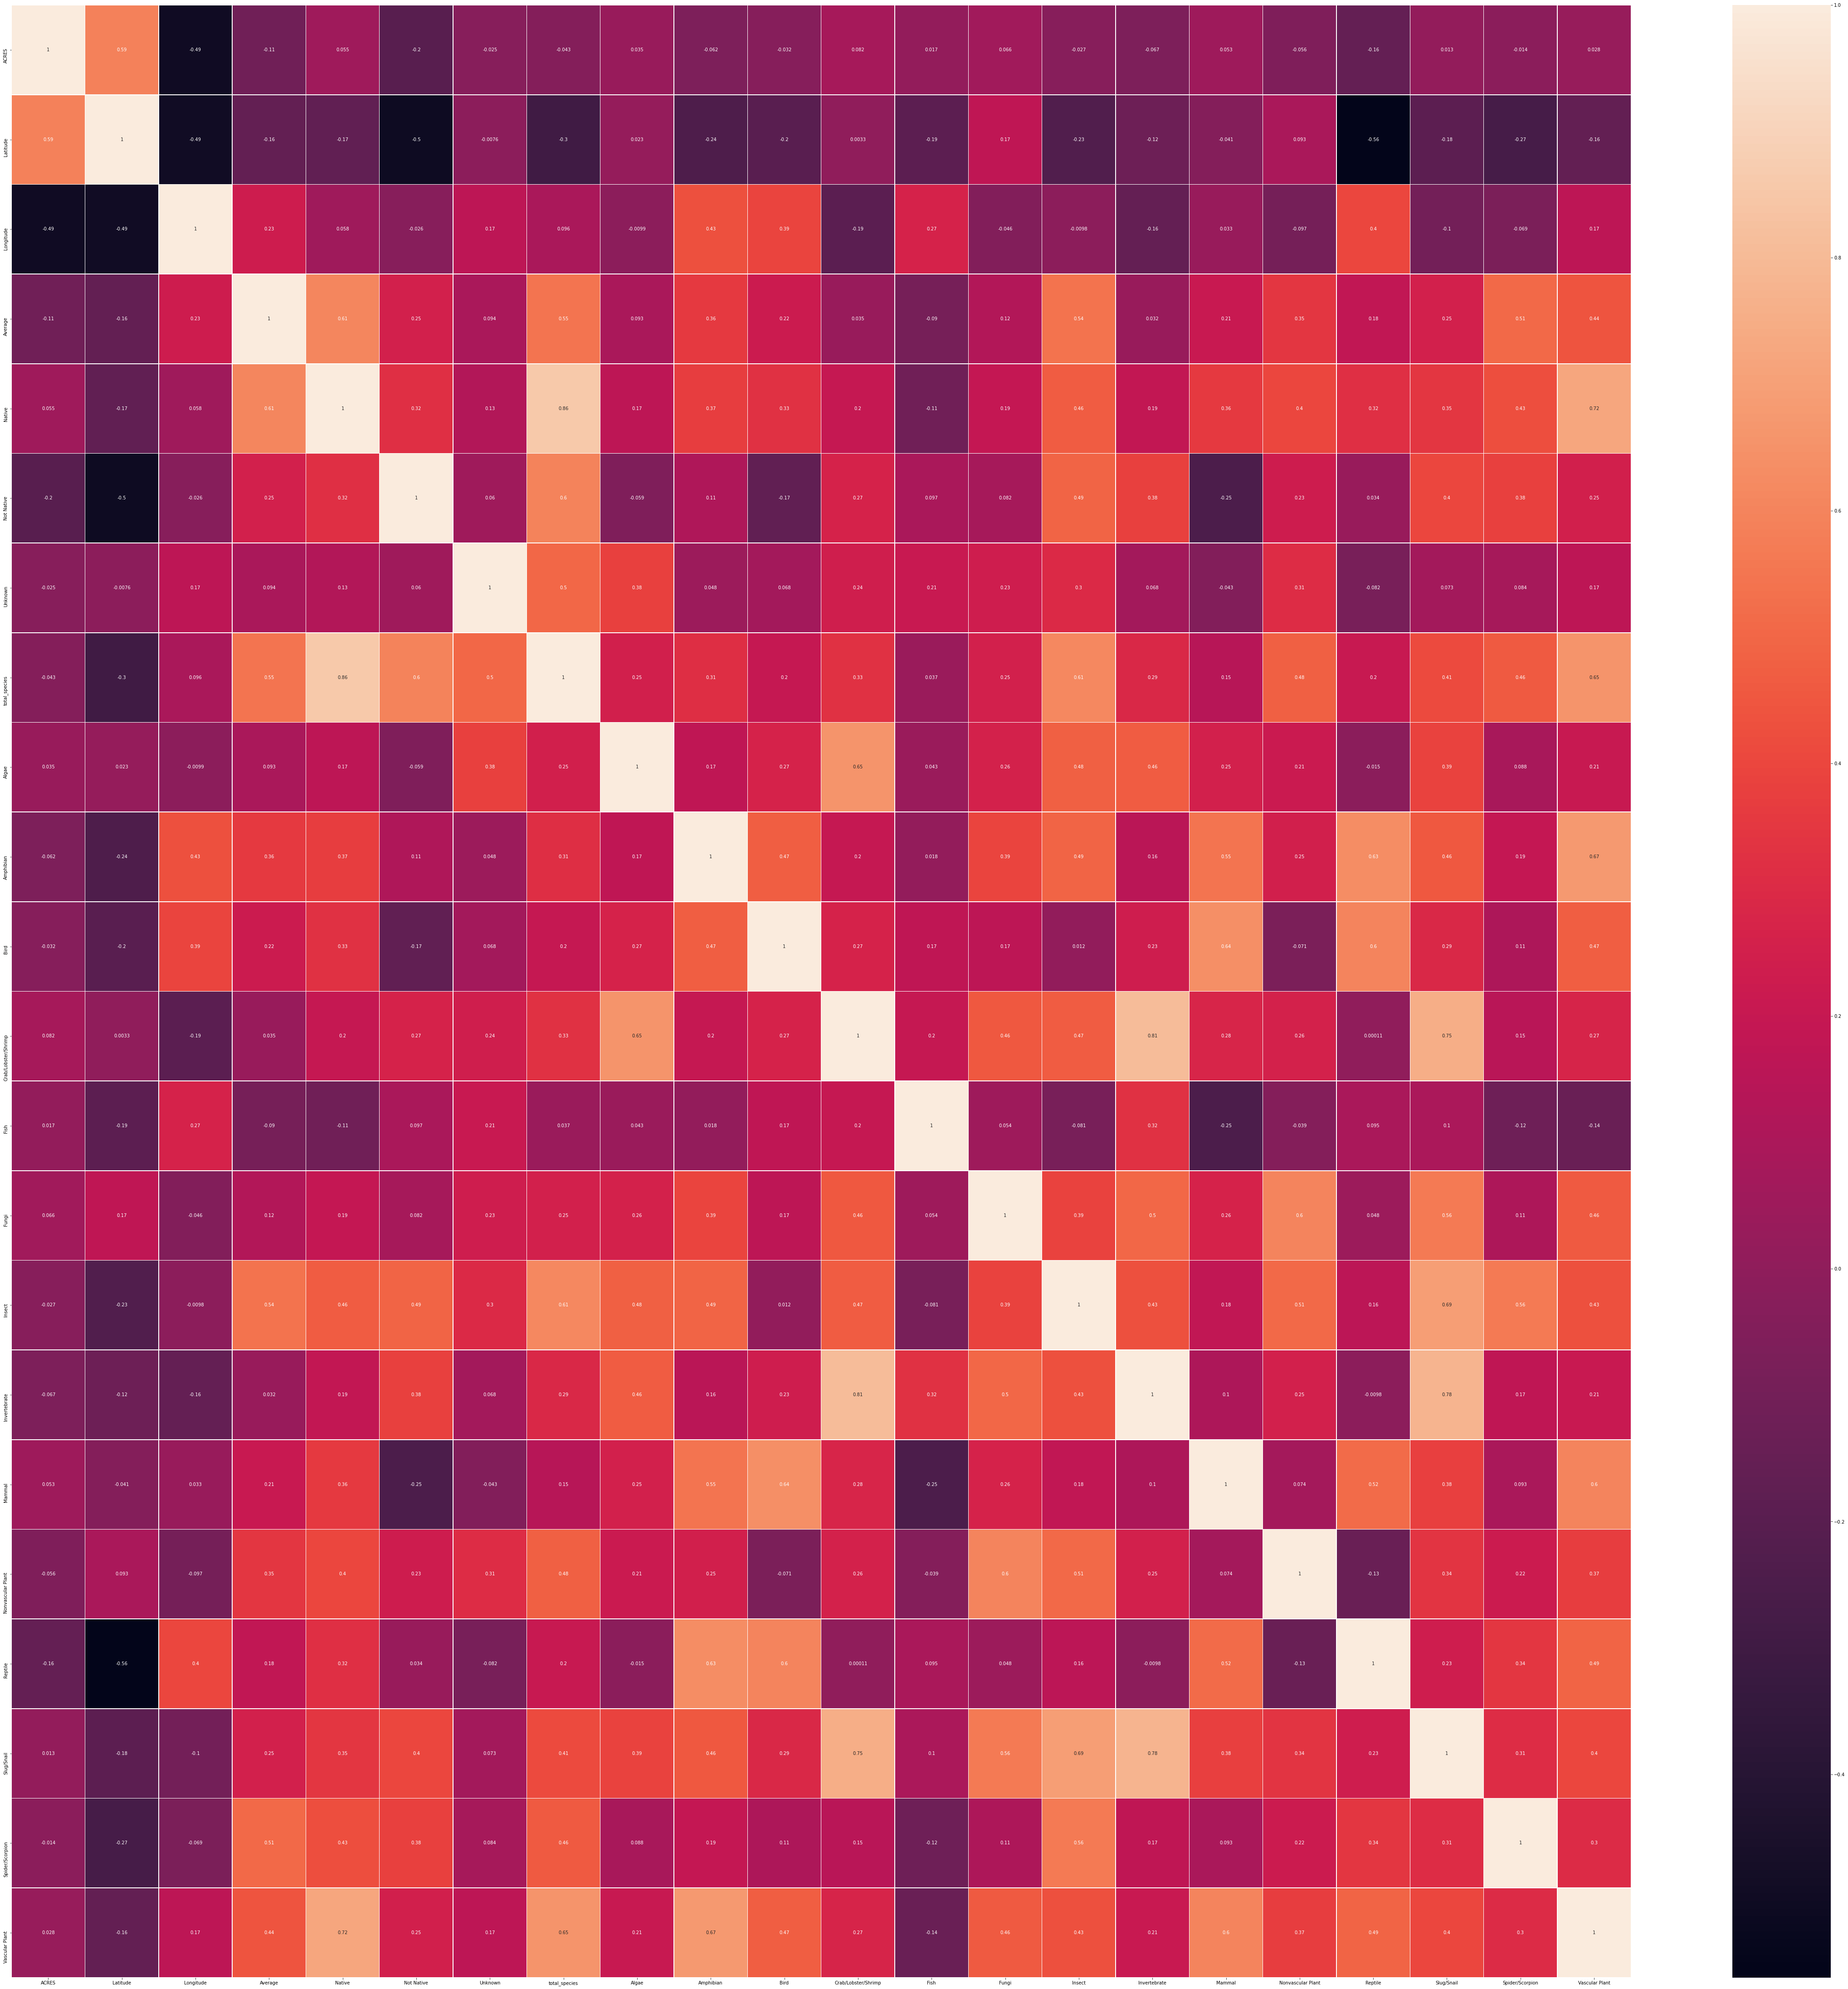

In [105]:
fig, ax = plt.subplots(figsize=(80,80))
sns.heatmap(biodiversity_df.corr(method='pearson'), annot=True, linewidths=.5, ax=ax)

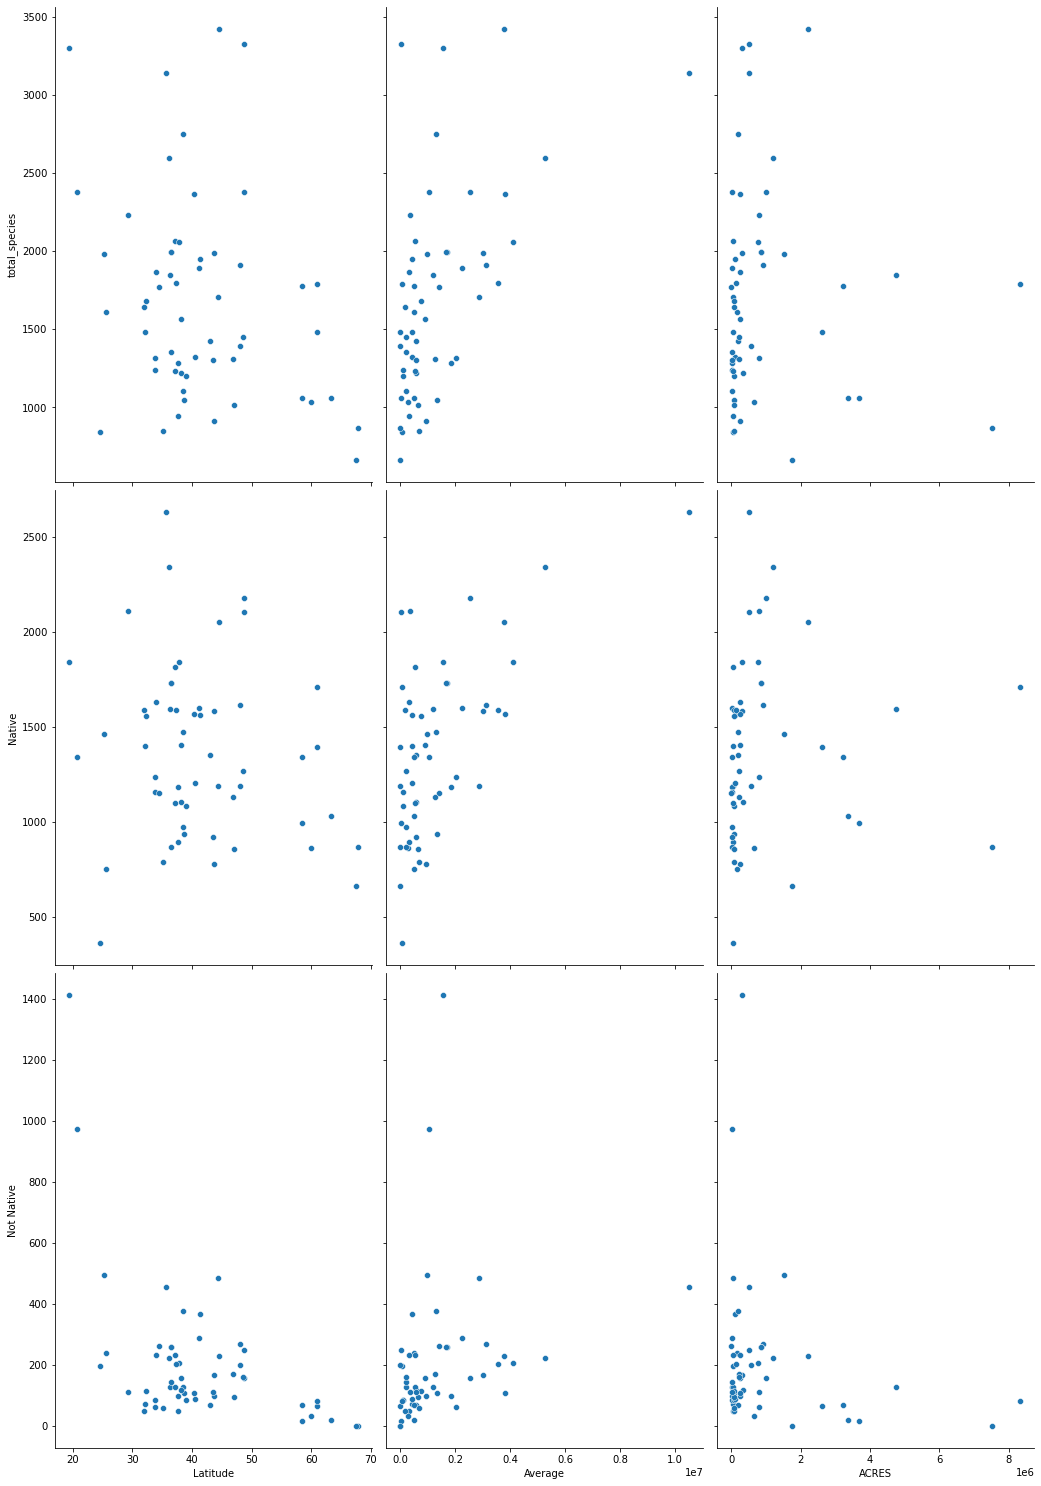

In [106]:
# Visualize the relationship between the features and the response using scatterplots
sns.pairplot(biodiversity_df, x_vars=['Latitude', 'Average', 'ACRES'], y_vars=['total_species', 'Native', 'Not Native'], height=7, aspect=.7)

##  Regression Model Testing

#### Park Visitation and Non Native Species

In [115]:
X = biodiversity_df.Average.values.reshape(-1,1)

In [116]:
y = biodiversity_df['Not Native'].values.reshape(-1,1)

In [117]:
#Fit and summarize model
model = LinearRegression()
mod = sm.OLS(y, X)
model.fit(X,y)
res = mod.fit()
y_pred = model.predict(X)
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.303
Model:                            OLS   Adj. R-squared (uncentered):              0.291
Method:                 Least Squares   F-statistic:                              24.40
Date:                Sat, 13 Mar 2021   Prob (F-statistic):                    7.43e-06
Time:                        22:16:27   Log-Likelihood:                         -395.76
No. Observations:                  57   AIC:                                      793.5
Df Residuals:                      56   BIC:                                      795.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [118]:
#Histogram
fig1 = px.histogram(biodiversity_df, x="Average")
fig1.show()

fig2 = px.histogram(biodiversity_df, x="Not Native")
fig2.show()



array([[<AxesSubplot:title={'center':'log_average_visitors'}>]],
      dtype=object)

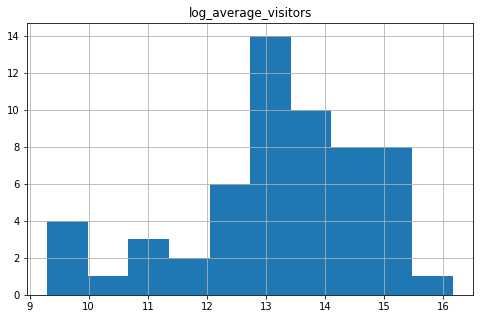

In [119]:
#Logarithmic Transformation
biodiversity_df['log_average_visitors'] = np.log(biodiversity_df['Average'])

#Histogram of transformed visitation
biodiversity_df.hist('log_average_visitors', figsize=(8,5))


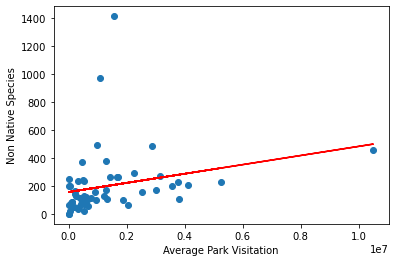

In [120]:
plt.scatter(X,y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Average Park Visitation')
plt.ylabel('Non Native Species')
plt.show()

In [121]:
#Calculate Root Mean Square Error of model
print('RMSE=>',  np.sqrt(mean_squared_error(y, y_pred)))

#Calculate R2 Score
print('R2 Score', metrics.r2_score(y, y_pred))

RMSE=> 217.44774855918524
R2 Score 0.06315550198271114


In [122]:
hover_label = biodiversity_df['Park Name']
fig = px.scatter(x= biodiversity_df['Average'], 
                 y=biodiversity_df['Not Native'], 
                color=biodiversity_df['Park Name'])

fig.update_layout(title='Park Visitation and Non Native Species')
fig.update_layout(
xaxis={'title': 'Average Park Visitation'},
yaxis={'title': 'Number Non Native Species'})

fig.show()

In [123]:
#Drop Hawaii Park outliers
biodiversity_df_noHawaii = biodiversity_df.drop([27, 28])
biodiversity_df_noHawaii

#Drop Great Smoky National Park outlier
biodiversity_df_drop_outliers = biodiversity_df_noHawaii.drop([25])

In [124]:
X = biodiversity_df_noHawaii.Average.values.reshape(-1,1)
y = biodiversity_df_noHawaii['Not Native'].values.reshape(-1,1)

In [125]:
#Fit and summarize model
model = LinearRegression()
mod = sm.OLS(y, X)
model.fit(X,y)
res = mod.fit()
y_pred = model.predict(X)
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.510
Model:                            OLS   Adj. R-squared (uncentered):              0.500
Method:                 Least Squares   F-statistic:                              56.11
Date:                Sat, 13 Mar 2021   Prob (F-statistic):                    6.59e-10
Time:                        22:16:53   Log-Likelihood:                         -349.81
No. Observations:                  55   AIC:                                      701.6
Df Residuals:                      54   BIC:                                      703.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [126]:
#Histogram
fig1 = px.histogram(biodiversity_df_noHawaii, x="Average")
fig1.show()

fig2 = px.histogram(biodiversity_df_noHawaii, x="Not Native")
fig2.show()

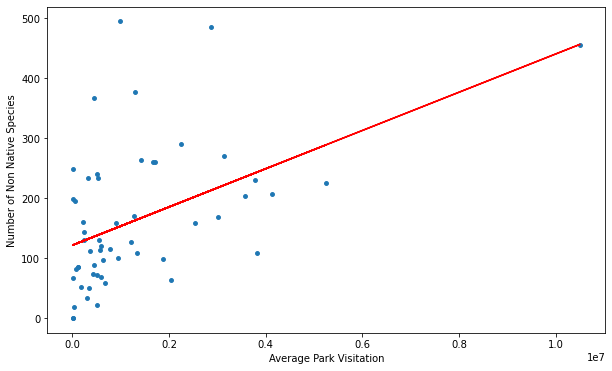

In [127]:
plt.figure(figsize=(10,6))
plt.scatter(X,y,s=15)
plt.plot(X, y_pred, color='red')
plt.xlabel('Average Park Visitation')
plt.ylabel('Number of Non Native Species')
plt.show()

In [128]:
#Calculate Root Mean Square Error
print('RMSE =>',  np.sqrt(mean_squared_error(y, y_pred)))
#Calculate R2 Score for Model
print('R2 Score', metrics.r2_score(y, y_pred))

RMSE => 100.59103910682107
R2 Score 0.23820639721901393


In [129]:
#Logarithmic Transformation Model
X = biodiversity_df_noHawaii.log_average_visitors.values.reshape(-1,1)
y = biodiversity_df_noHawaii['Not Native'].values.reshape(-1,1)

#Fit and summarize model
model = LinearRegression()
mod = sm.OLS(y, X)
model.fit(X,y)
res = mod.fit()
y_pred = model.predict(X)
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.710
Model:                            OLS   Adj. R-squared (uncentered):              0.705
Method:                 Least Squares   F-statistic:                              132.1
Date:                Sat, 13 Mar 2021   Prob (F-statistic):                    3.92e-16
Time:                        22:16:58   Log-Likelihood:                         -335.37
No. Observations:                  55   AIC:                                      672.7
Df Residuals:                      54   BIC:                                      674.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [130]:
#Histogram
fig1 = px.histogram(biodiversity_df_noHawaii, x="log_average_visitors")
fig1.show()

fig2 = px.histogram(biodiversity_df_noHawaii, x="Not Native")
fig2.show()

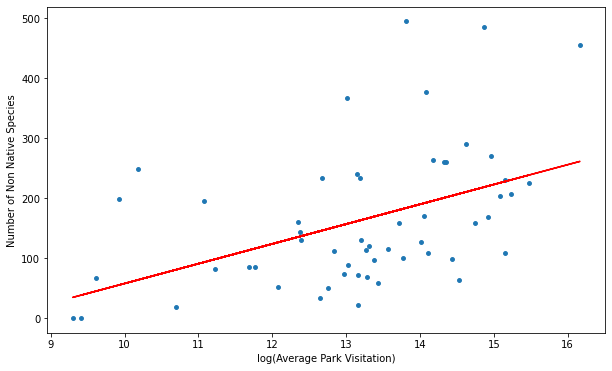

In [131]:
plt.figure(figsize=(10,6))
plt.scatter(X,y,s=15)
plt.plot(X, y_pred, color='red')
plt.xlabel('log(Average Park Visitation)')
plt.ylabel('Number of Non Native Species')
plt.show()

In [132]:
#Calculate Root Mean Square Error
print('RMSE =>',  np.sqrt(mean_squared_error(y, y_pred)))
#Calculate R2 Score for Model
print('R2 Score', metrics.r2_score(y, y_pred))

RMSE => 102.54070318332823
R2 Score 0.20838992103803988


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.712
Model:                            OLS   Adj. R-squared (uncentered):              0.707
Method:                 Least Squares   F-statistic:                              131.1
Date:                Sat, 13 Mar 2021   Prob (F-statistic):                    5.95e-16
Time:                        22:17:10   Log-Likelihood:                         -326.87
No. Observations:                  54   AIC:                                      655.7
Df Residuals:                      53   BIC:                                      657.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

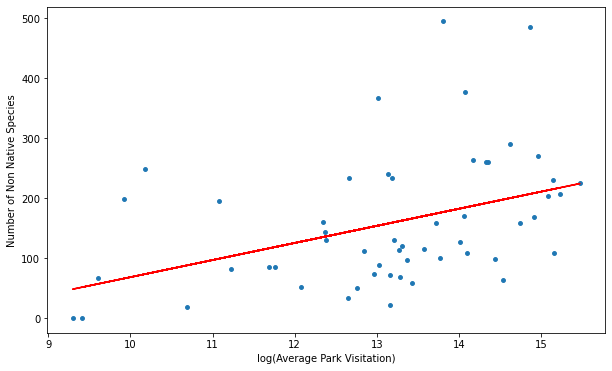

In [133]:
#Remove Great Smoky Mtn. National Park as an Outlier for Visitation
X = biodiversity_df_drop_outliers.log_average_visitors.values.reshape(-1,1)
y = biodiversity_df_drop_outliers['Not Native'].values.reshape(-1,1)

#Fit and summarize model
model = LinearRegression()
mod = sm.OLS(y, X)
model.fit(X,y)
res = mod.fit()
y_pred = model.predict(X)
print(res.summary())

#Plot Figure
plt.figure(figsize=(10,6))
plt.scatter(X,y,s=15)
plt.plot(X, y_pred, color='red')
plt.xlabel('log(Average Park Visitation)')
plt.ylabel('Number of Non Native Species')
plt.show()

In [134]:
#Calculate Root Mean Square Error
print('RMSE =>',  np.sqrt(mean_squared_error(y, y_pred)))
#Calculate R2 Score for Model
print('R2 Score', metrics.r2_score(y, y_pred))

RMSE => 99.72929691776663
R2 Score 0.1650417103626216


In [135]:
#Histogram
fig1 = px.histogram(biodiversity_df_drop_outliers, x="log_average_visitors")
fig1.show()

fig2 = px.histogram(biodiversity_df_drop_outliers, x="Not Native")
fig2.show()

In [159]:
#Try a log tranformation on Non Native Species

#Drop rows where non native species are equal to 0
biodiversity_drop_zeros = biodiversity_df[biodiversity_df['Not Native'] != 0].copy()
biodiversity_drop_zeros.head()

,Park Name,Park Code,State,ACRES,Latitude,Longitude,Average,Native,Not Native,Unknown,...,Fungi,Insect,Invertebrate,Mammal,Nonvascular Plant,Reptile,Slug/Snail,Spider/Scorpion,Vascular Plant,log_average_visitors
0,Acadia National Park,ACAD,ME,47390,44.35,-68.21,2872667,1189.0,486.0,33.0,...,0.0,0.0,0.0,55.0,0.0,11.0,0.0,0.0,1226.0,14.870751
1,Arches National Park,ARCH,UT,76519,38.68,-109.57,1334063,939.0,108.0,1.0,...,0.0,0.0,0.0,59.0,0.0,20.0,0.0,0.0,745.0,14.103740
2,Badlands National Park,BADL,SD,242756,43.75,-102.50,951227,779.0,100.0,35.0,...,173.0,239.0,1.0,64.0,0.0,13.0,0.0,1.0,625.0,13.765508
3,Big Bend National Park,BIBE,TX,801163,29.25,-103.25,377154,2108.0,112.0,9.0,...,0.0,0.0,0.0,89.0,48.0,62.0,0.0,0.0,1589.0,12.840409
4,Biscayne National Park,BISC,FL,172924,25.65,-80.08,509950,751.0,241.0,620.0,...,0.0,11.0,34.0,28.0,0.0,40.0,0.0,0.0,554.0,13.142068


array([[<AxesSubplot:title={'center':'log_average_visitors'}>]],
      dtype=object)

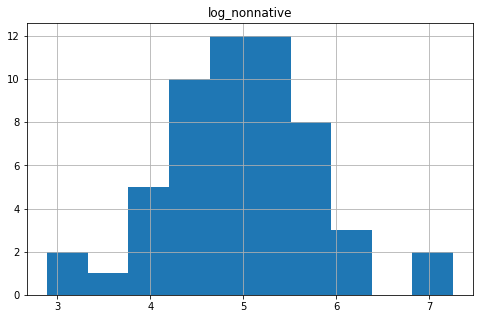

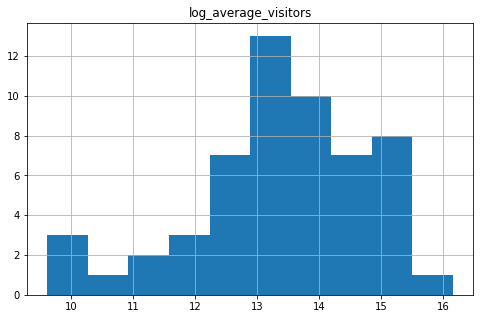

In [160]:
#Logarithmic transformation of Non Native Species
biodiversity_drop_zeros['log_nonnative'] = np.log(biodiversity_drop_zeros['Not Native'])

#Histograms
biodiversity_drop_zeros.hist('log_nonnative', figsize=(8,5))
biodiversity_drop_zeros.hist('log_average_visitors', figsize=(8,5))

In [161]:
X = biodiversity_drop_zeros.log_average_visitors.values.reshape(-1,1)
y = biodiversity_drop_zeros.log_nonnative.values.reshape(-1,1)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.976
Method:                 Least Squares   F-statistic:                              2231.
Date:                Sat, 13 Mar 2021   Prob (F-statistic):                    1.33e-45
Time:                        22:42:45   Log-Likelihood:                         -64.078
No. Observations:                  55   AIC:                                      130.2
Df Residuals:                      54   BIC:                                      132.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

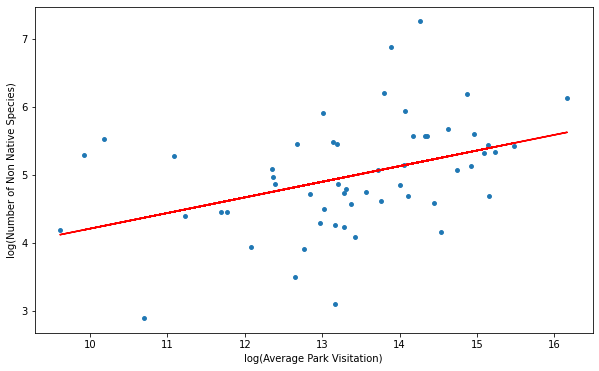

In [162]:
#Fit and summarize model
model = LinearRegression()
mod = sm.OLS(y, X)
model.fit(X,y)
res = mod.fit()
y_pred = model.predict(X)
print(res.summary())

#Plot Figure
plt.figure(figsize=(10,6))
plt.scatter(X,y,s=15)
plt.plot(X, y_pred, color='red')
plt.xlabel('log(Average Park Visitation)')
plt.ylabel('log(Number of Non Native Species)')
plt.show()

In [163]:
#Calculate Root Mean Square Error
print('RMSE =>',  np.sqrt(mean_squared_error(y, y_pred)))
#Calculate R2 Score for Model
print('R2 Score', metrics.r2_score(y, y_pred))

RMSE => 0.7494630179539646
R2 Score 0.15810692386807101


#### Park Size and Total Number of Species (Species Richness)

In [77]:
X = biodiversity_df.ACRES.values.reshape(-1,1)
y = biodiversity_df.total_species.values.reshape(-1,1)

In [78]:
#Fit and summarize model
model = LinearRegression()
mod = sm.OLS(y, X)
model.fit(X,y)
res = mod.fit()
y_pred = model.predict(X)
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.192
Model:                            OLS   Adj. R-squared (uncentered):              0.178
Method:                 Least Squares   F-statistic:                              13.31
Date:                Sat, 13 Mar 2021   Prob (F-statistic):                    0.000581
Time:                        22:04:19   Log-Likelihood:                         -502.25
No. Observations:                  57   AIC:                                      1007.
Df Residuals:                      56   BIC:                                      1009.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [79]:
#Histogram
fig1 = px.histogram(biodiversity_df, x="ACRES")
fig1.show()

fig2 = px.histogram(biodiversity_df, x="total_species")
fig2.show()

array([[<AxesSubplot:title={'center':'log_park_size'}>]], dtype=object)

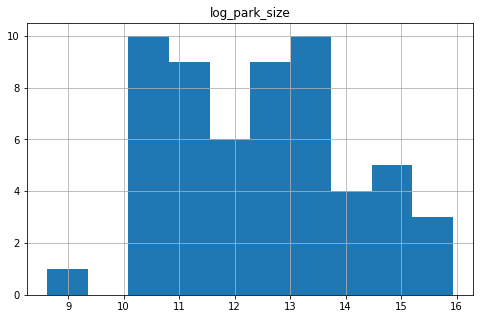

In [80]:
#Logarithmic Transformation
biodiversity_df['log_park_size'] = np.log(biodiversity_df['ACRES'])

#Histogram of transformed visitation
biodiversity_df.hist('log_park_size', figsize=(8,5))

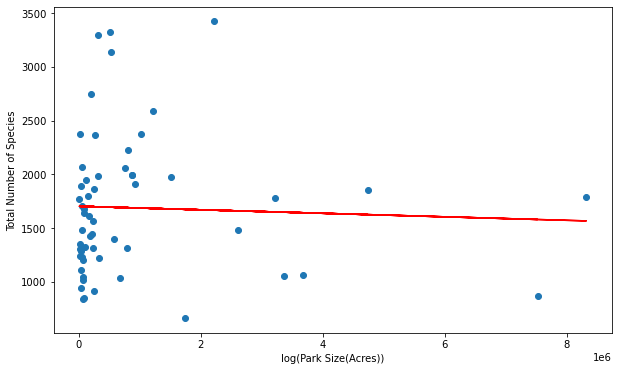

In [81]:
plt.figure(figsize=(10,6))
plt.scatter(X,y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Park Size(Acres)')
plt.ylabel('Total Number of Species')
plt.show()

In [82]:
#Calculate Root Mean Square Error
mean_squared_error(y, y_pred)
print('RMSE =>',  np.sqrt(mean_squared_error(y, y_pred)))
#Calculate R2 score
metrics.r2_score(y, y_pred)
print('R2 Score =', metrics.r2_score(y, y_pred))

RMSE => 643.7855562957948
R2 Score = 0.0018126003894950449


In [83]:
#Log Transformation Model
X = biodiversity_df.log_park_size.values.reshape(-1,1)
y = biodiversity_df.total_species.values.reshape(-1,1)

In [84]:
#Fit and summarize model
model = LinearRegression()
mod = sm.OLS(y, X)
model.fit(X,y)
res = mod.fit()
y_pred = model.predict(X)
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.873
Model:                            OLS   Adj. R-squared (uncentered):              0.871
Method:                 Least Squares   F-statistic:                              385.5
Date:                Sat, 13 Mar 2021   Prob (F-statistic):                    8.83e-27
Time:                        22:07:55   Log-Likelihood:                         -449.48
No. Observations:                  57   AIC:                                      901.0
Df Residuals:                      56   BIC:                                      903.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

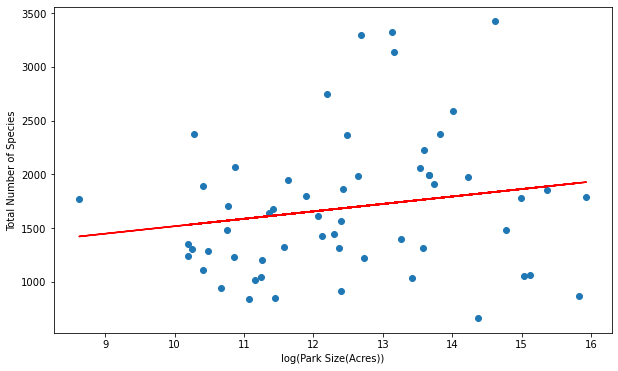

In [85]:
plt.figure(figsize=(10,6))
plt.scatter(X,y)
plt.plot(X, y_pred, color='red')
plt.xlabel('log(Park Size(Acres))')
plt.ylabel('Total Number of Species')
plt.show()

In [86]:
#Calculate Root Mean Square Error
mean_squared_error(y, y_pred)
print('RMSE =>',  np.sqrt(mean_squared_error(y, y_pred)))
#Calculate R2 score
metrics.r2_score(y, y_pred)
print('R2 Score =', metrics.r2_score(y, y_pred))

RMSE => 634.055525281895
R2 Score = 0.031757350727018796


#### Exploring Latitude and Species Richness

In [87]:
X= biodiversity_df.Latitude.values.reshape(-1,1)
y= biodiversity_df.total_species.values.reshape(-1,1)

#Fit and summarize model
model = LinearRegression()
mod = sm.OLS(y, X)
model.fit(X,y)
res = mod.fit()
y_pred = model.predict(X)
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.770
Model:                            OLS   Adj. R-squared (uncentered):              0.766
Method:                 Least Squares   F-statistic:                              187.3
Date:                Sat, 13 Mar 2021   Prob (F-statistic):                    1.66e-19
Time:                        22:09:13   Log-Likelihood:                         -466.47
No. Observations:                  57   AIC:                                      934.9
Df Residuals:                      56   BIC:                                      937.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [88]:
#Histogram
fig1 = px.histogram(biodiversity_df, x="Latitude")
fig1.show()

fig2 = px.histogram(biodiversity_df, x="total_species")
fig2.show()

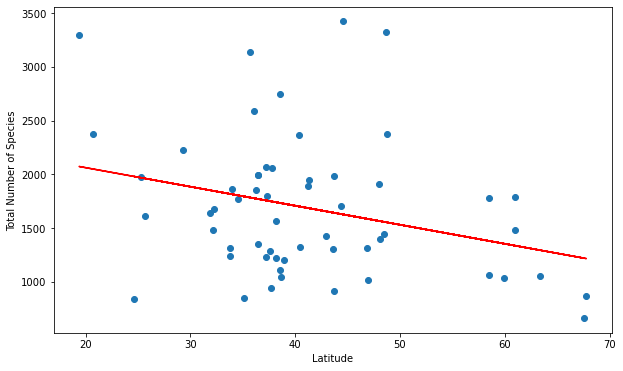

In [89]:
plt.figure(figsize=(10,6))
plt.scatter(X,y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Latitude')
plt.ylabel('Total Number of Species')
plt.show()

In [90]:
#Calculate Root Mean Square Error
print('RMSE =>', np.sqrt(mean_squared_error(y, y_pred)))

#Calculate R2 score

print('R2 Score', metrics.r2_score(y, y_pred))

RMSE => 615.6661796978447
R2 Score 0.0871062785899187


####  Exploring Latitude and Non Native Species

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.299
Model:                            OLS   Adj. R-squared (uncentered):              0.287
Method:                 Least Squares   F-statistic:                              23.93
Date:                Sat, 13 Mar 2021   Prob (F-statistic):                    8.80e-06
Time:                        22:09:31   Log-Likelihood:                         -395.93
No. Observations:                  57   AIC:                                      793.9
Df Residuals:                      56   BIC:                                      795.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

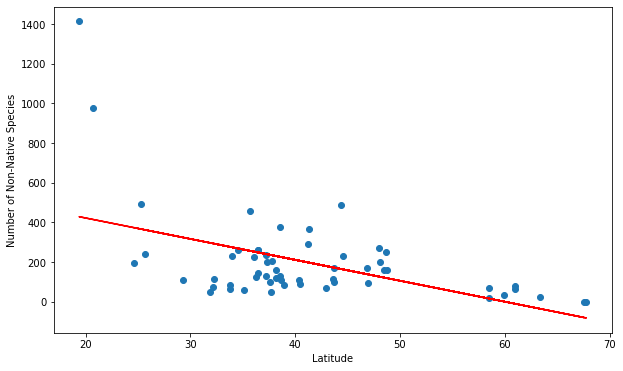

In [91]:
X = biodiversity_df.Latitude.values.reshape(-1,1)
y = biodiversity_df['Not Native'].values.reshape(-1,1)

#Fit and summarize model
model = LinearRegression()
mod = sm.OLS(y, X)
model.fit(X,y)
res = mod.fit()
y_pred = model.predict(X)
print(res.summary())

plt.figure(figsize=(10,6))
plt.scatter(X,y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Latitude')
plt.ylabel('Number of Non-Native Species')
plt.show()

In [92]:
#Histogram
fig1 = px.histogram(biodiversity_df, x="Latitude")
fig1.show()

fig2 = px.histogram(biodiversity_df, x="Not Native")
fig2.show()

In [93]:
#Calculate Root Mean Square Error
print('RMSE for Linear Regression=>', np.sqrt(mean_squared_error(y, y_pred)))

#Calculate R2 Score for Model
print('R2 Score =', metrics.r2_score(y, y_pred))

RMSE for Linear Regression=> 194.03817855730256
R2 Score = 0.2540116274894847


In [94]:
# importing libraries for polynomial transform
from sklearn.preprocessing import PolynomialFeatures
# for creating pipeline
from sklearn.pipeline import Pipeline
# creating pipeline and fitting it on data
Input=[('polynomial',PolynomialFeatures(degree=2)),('modal',LinearRegression())]
pipe=Pipeline(Input)
pipe.fit(X,y)

Pipeline(steps=[('polynomial', PolynomialFeatures()),
                ('modal', LinearRegression())])

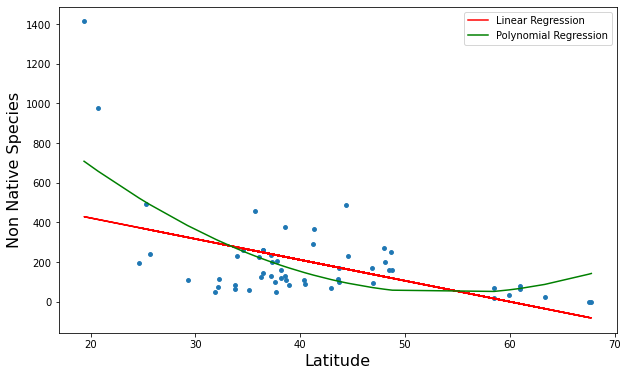

In [95]:
poly_pred=pipe.predict(X)
#sorting predicted values with respect to predictor
sorted_zip = sorted(zip(X,poly_pred))
X_poly, poly_pred = zip(*sorted_zip)
#plotting predictions
plt.figure(figsize=(10,6))
plt.scatter(X,y,s=15)
plt.plot(X,y_pred,color='r',label='Linear Regression')
plt.plot(X_poly,poly_pred,color='g',label='Polynomial Regression')
plt.xlabel('Latitude',fontsize=16)
plt.ylabel('Non Native Species',fontsize=16)
plt.legend()
plt.show()

In [96]:
#Calculate Root Mean Square Error
print('RMSE for Polynomial Regression=>', np.sqrt(mean_squared_error(y, poly_pred)))

#Calculate R2 Score
print('R2 Score', metrics.r2_score(y, y_pred))

RMSE for Polynomial Regression=> 264.2789178951947
R2 Score 0.2540116274894847


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.548
Model:                            OLS   Adj. R-squared (uncentered):              0.540
Method:                 Least Squares   F-statistic:                              65.47
Date:                Sat, 13 Mar 2021   Prob (F-statistic):                    7.03e-11
Time:                        22:12:22   Log-Likelihood:                         -347.56
No. Observations:                  55   AIC:                                      697.1
Df Residuals:                      54   BIC:                                      699.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

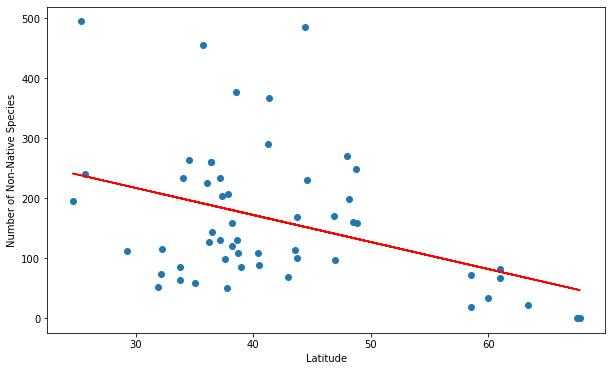

In [97]:
#Remove Hawaii Outliers and re-run linear regression

X = biodiversity_df_noHawaii.Latitude.values.reshape(-1,1)
y = biodiversity_df_noHawaii['Not Native'].values.reshape(-1,1)

#Fit and summarize model
model = LinearRegression()
mod = sm.OLS(y, X)
model.fit(X,y)
res = mod.fit()
y_pred = model.predict(X)
print(res.summary())

plt.figure(figsize=(10,6))
plt.scatter(X,y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Latitude')
plt.ylabel('Number of Non-Native Species')
plt.show()

In [98]:
#Calculate Root Mean Square Error
print('RMSE for Linear Regression=>', np.sqrt(mean_squared_error(y, y_pred)))

#Calculate R2 Score for Model
print('R2 Score =', metrics.r2_score(y, y_pred))

RMSE for Linear Regression=> 105.78266636745828
R2 Score = 0.15754298330126237
